In [3]:
import sys
sys.path.append('../')

,image_name,label,path,train,label_id,image_id
0,n07720875_1.JPEG,bell pepper,images/bell pepper/n07720875_1.JPEG,True,0,0
1,n07720875_10.JPEG,bell pepper,images/bell pepper/n07720875_10.JPEG,True,0,1
2,n07720875_101.JPEG,bell pepper,images/bell pepper/n07720875_101.JPEG,True,0,2
3,n07720875_104.JPEG,bell pepper,images/bell pepper/n07720875_104.JPEG,True,0,3


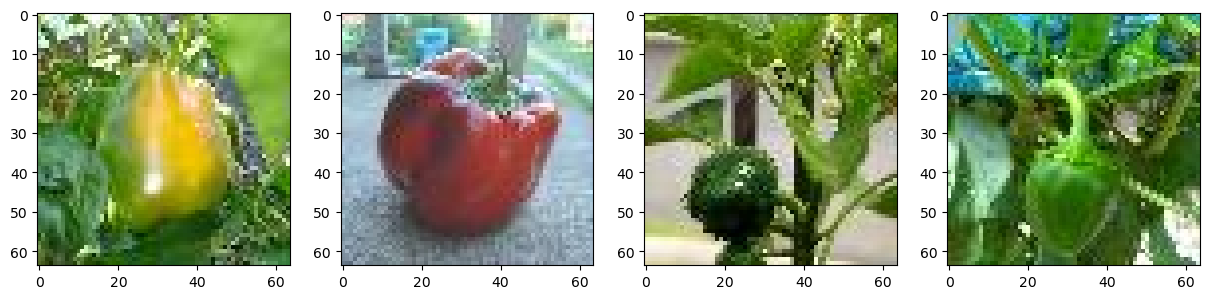

In [4]:
import cv2                      # Image Ops
import pandas as pd             # Other
import numpy as np              # Mat Opts
import matplotlib.pyplot as plt # Show Images

from utils.utils import load_images
from utils.features import load_features, save_features, extract_features
from utils.matching import minmin_retrival, match_all_images
from utils.scoring import calculate_metrics

from functools import partial
from sklearn.cluster import KMeans

image_meta, images = load_images(True) # True - Train Images
display(image_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(images[0]);
ax[1].imshow(images[1]);
ax[2].imshow(images[2]);
ax[3].imshow(images[3]);

# Características
Se plantea usar como características el histograma de diferencia de color para imágenes RGB. Se explica en la [siguiente publicación](https://www.sciencedirect.com/science/article/pii/S0031320312002713?via%3Dihub)
 

In [5]:
b = 32
def normalize(vector):
    return vector / np.linalg.norm(vector)

def same(x): return x

def cch_descriptor(image, bins = 32):
    rbin = normalize(np.histogram(image[:, :, 0], bins = bins, range = [0, 255])[0])
    gbin = normalize(np.histogram(image[:, :, 1], bins = bins, range = [0, 255])[0])
    bbin = normalize(np.histogram(image[:, :, 2], bins = bins, range = [0, 255])[0])
    return np.concatenate([rbin, gbin, bbin], axis = 0).reshape(1, -1).astype(np.float32) # Un Vector con solo columnas

cch_descriptor_func = partial(cch_descriptor, bins = b)

# Convertir las imágenes a escala de grises y aplicar SIFT en el subconjunto de imágenes
descriptors, index = extract_features(cch_descriptor_func, images, min_features=1, progress = True)
print("Tamaño de  descriptores:", descriptors.shape[1])
print("Número de  descriptores:", descriptors.shape[0])
print("Número Máximo de Descriptores Por Imágen :", pd.value_counts(index).max())
print("Número Medio  de Descriptores Por Imágen :", pd.value_counts(index).mean().round(0).astype(int))
print("Número Mínimo de Descriptores Por Imágen :", pd.value_counts(index).min())

# Obligatorio Siempre Guardar
save_features(descriptors, index, image_meta, "CCH")
descriptors[:5, :5]

  0%|          | 0/700 [00:00<?, ?it/s]

Tamaño de  descriptores: 96
Número de  descriptores: 700
Número Máximo de Descriptores Por Imágen : 1
Número Medio  de Descriptores Por Imágen : 1
Número Mínimo de Descriptores Por Imágen : 1


array([[0.01723524, 0.03939483, 0.07263421, 0.13172646, 0.17235237],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.139363  , 0.13189712, 0.10825519, 0.09456775, 0.10078931],
       [0.0685756 , 0.06073838, 0.11168026, 0.19103202, 0.31936637],
       [0.03552246, 0.01665115, 0.03219223, 0.05661392, 0.10545731]],
      dtype=float32)

In [6]:
desc_meta, descriptors = load_features("../features/CCH.csv") # Siempre Cargar
display(desc_meta.head())
display(descriptors.dtype)

,image_id,label_id
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


dtype('float32')

,image_name,label,path,train,label_id,image_id
0,n07720875_0.JPEG,bell pepper,images/bell pepper/n07720875_0.JPEG,False,0,0
1,n07720875_100.JPEG,bell pepper,images/bell pepper/n07720875_100.JPEG,False,0,1
2,n07720875_102.JPEG,bell pepper,images/bell pepper/n07720875_102.JPEG,False,0,2
3,n07720875_103.JPEG,bell pepper,images/bell pepper/n07720875_103.JPEG,False,0,3


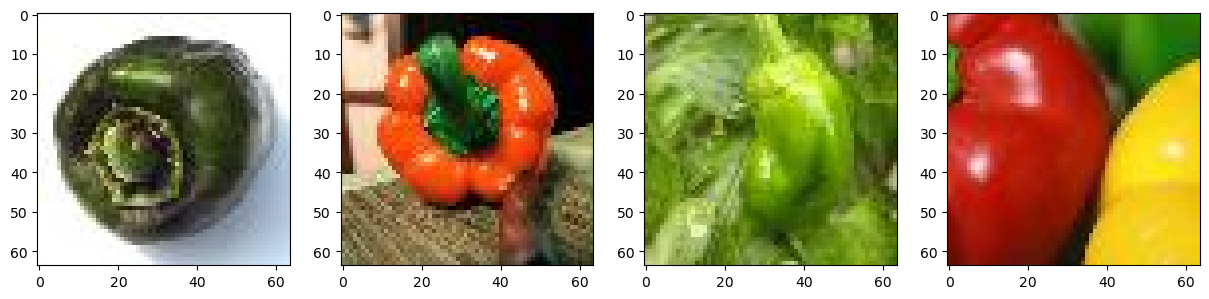

In [7]:
test_meta, test_images = load_images(False)

display(test_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(test_images[0]);
ax[1].imshow(test_images[1]);
ax[2].imshow(test_images[2]);
ax[3].imshow(test_images[3]);


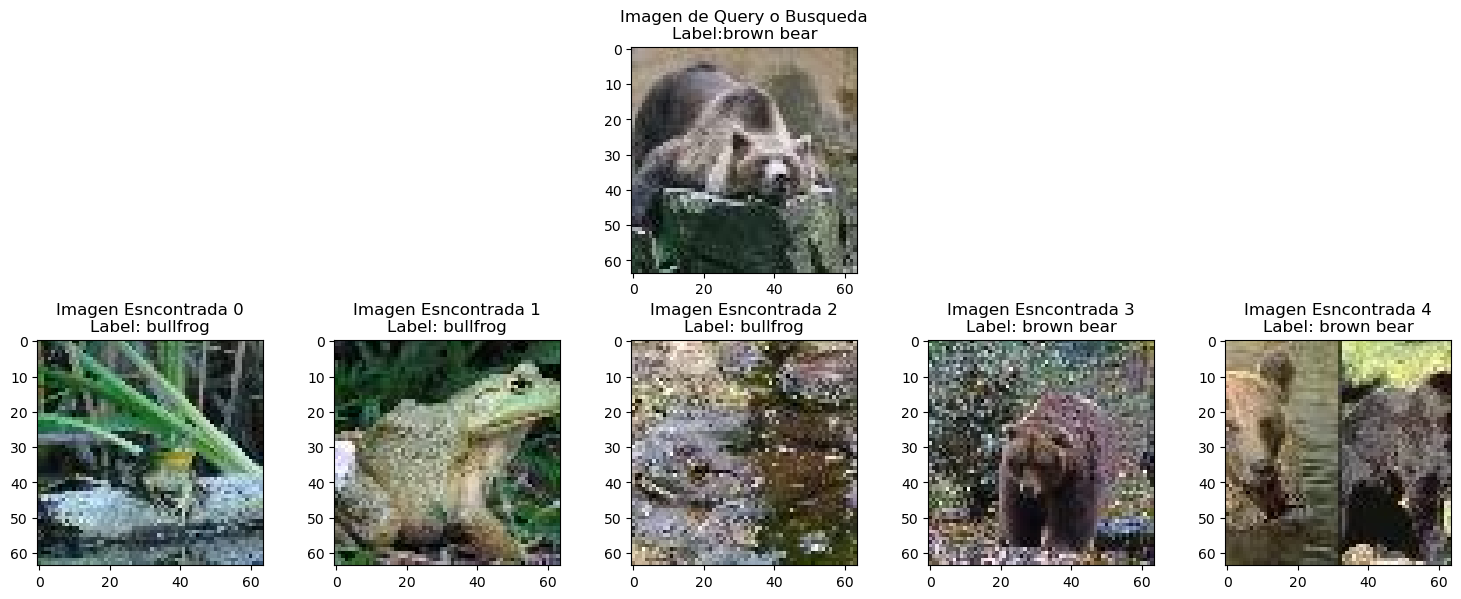

In [8]:
img = test_images[50]
descs = partial(cch_descriptor, bins = b)(img)
ret_idx = minmin_retrival(descs, descriptors, desc_meta, best_k=5, distance_function=cv2.NORM_L2)

fig, ax = plt.subplots(2, 5,  figsize = (15, 6))

test_img = 50
ax[0][2].imshow(img)
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(ret_idx[:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Esncontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


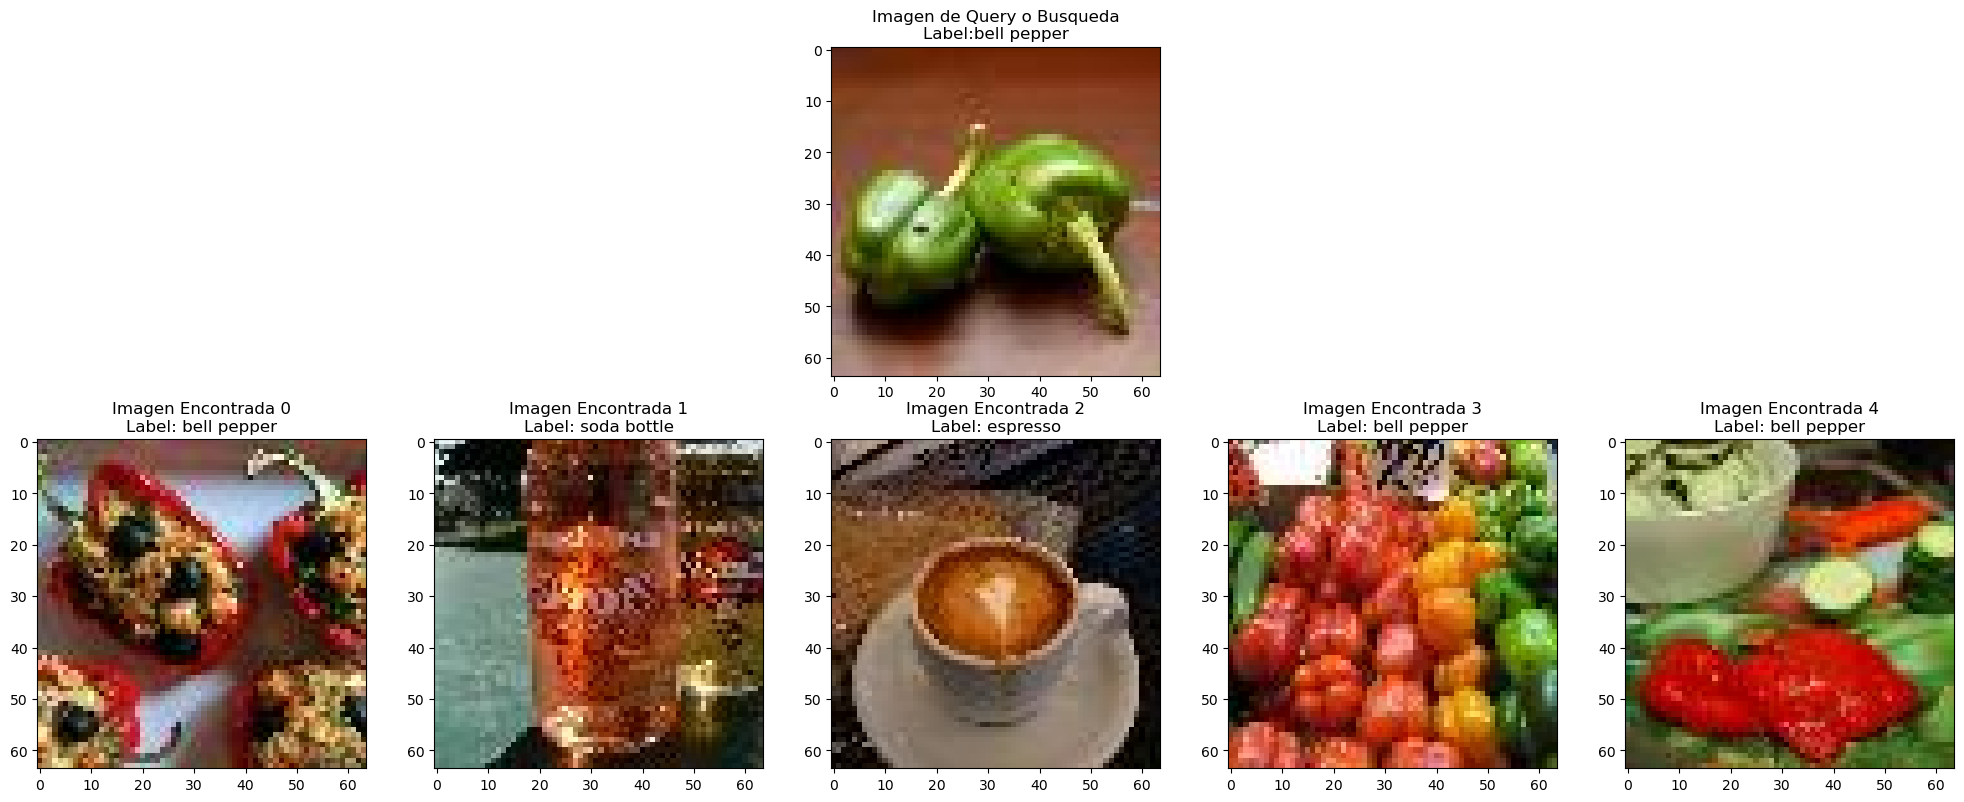

In [9]:
test_decs, test_desc_meta = extract_features(partial(cch_descriptor, bins = b), test_images, progress=False)

xr = match_all_images(test_decs, test_meta, descriptors, desc_meta, best_k=35, distance_function=cv2.NORM_L1)
fig, ax = plt.subplots(2, 5,  figsize = (20, 8))

test_img = 10
ax[0][2].imshow(test_images[test_img])
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(xr[test_img][:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


In [10]:
calculate_metrics(xr, image_meta, test_meta, scores = (1, 5, 10, 25, 50))

,Precision@K,Recall@K,R-Precision@K
K,,,
1,0.263333,0.003762,0.263333
5,0.199333,0.014238,0.199333
10,0.182333,0.026048,0.182333
25,0.161200,0.057571,0.161200


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


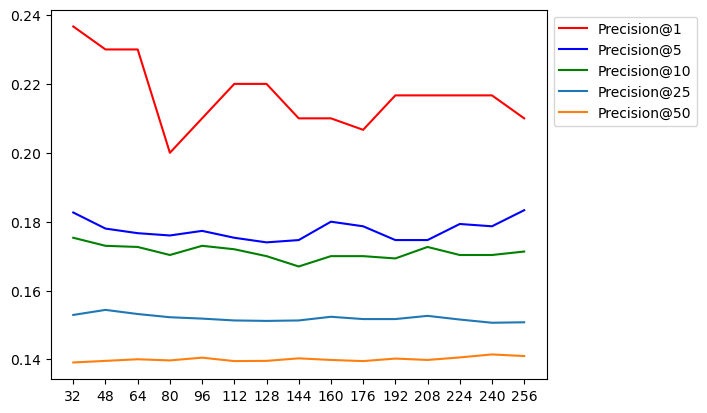

In [11]:
from tqdm import tqdm
scores1 = []
scores5 = []
scores10 = []
scores25 = []
scores50 = []
params = list(range(32, 257, 16))
k = [20, 30, 40]
for b in tqdm(params):
    cch_descriptor_func = partial(cch_descriptor, bins = b) 

    train_desc, train_index = extract_features(cch_descriptor_func, images)
    
    test_desc , test_index  = extract_features(cch_descriptor_func, test_images)

    results = match_all_images(test_desc, test_index, train_desc, train_index, best_k=50, distance_function=cv2.NORM_L2)
    rprecision = calculate_metrics(results, image_meta, test_meta, scores = (1, 5, 10, 25, 50))

    scores1.append( rprecision.loc[ 1, 'Precision@K'])
    scores5.append( rprecision.loc[ 5, 'Precision@K'])
    scores10.append(rprecision.loc[10, 'Precision@K'])
    scores25.append(rprecision.loc[25, 'Precision@K'])
    scores50.append(rprecision.loc[50, 'Precision@K'])

plt.plot(params, scores1 , 'r', label = "Precision@1")
plt.plot(params, scores5 , 'b', label = "Precision@5")
plt.plot(params, scores10, 'g', label = "Precision@10")
plt.plot(params, scores25,      label = "Precision@25")
plt.plot(params, scores50,      label = "Precision@50")
plt.xticks(params)
plt.legend(bbox_to_anchor = (1, 1))
plt.show()